In [349]:
import numpy as np
import sentle
from sentle import sentle
from dotenv import load_dotenv
import geopandas as gpd
# import pandas as pd
# from pathlib import Path
import os
# import torch
import matplotlib.pyplot as plt
# import fiona
import logging
import time
# import rioxarray
from shapely.geometry import mapping 
import pyogrio
import spyndex
import xarray as xr
from shapely import wkt

# Load in gpkg from PreProcessing Step 

In [207]:
wheat_hd = gpd.read_file('/net/projects/EO4BK/WP1/P1-EO4BK/scripts/EO4BK-WP1-P1/data/eo4bkclasses/wheat_eo4bk.gpkg', layer = 'hd_data')

# Download Data

In [341]:
def sentle_download(lcs_eo4bkdata, time_span:str ):


    boundary = lcs_eo4bkdata.geometry.bounds
    bound_left = int(boundary.minx.iloc[0])
    bound_bottom = int(boundary.miny.iloc[0])
    bound_right = int(boundary.maxx.iloc[0])
    bound_top = int(boundary.maxy.iloc[0])

    da = sentle.process(target_crs= lcs_eo4bkdata.crs,
                        bound_left=bound_left,
                        bound_bottom=bound_bottom,
                        bound_right=bound_right,
                        bound_top=bound_top,
                        datetime=time_span,
                        target_resolution=20,
                        dask_scheduler_port=10012,
                        dask_dashboard_address='127.0.0.1:37382',
                        S2_mask_snow=True,
                        S2_cloud_classification=True,
                        S2_cloud_classification_device="cpu",
                        S1_assets=["vv", "vh"],
                        S2_apply_snow_mask=True,
                        S2_apply_cloud_mask=True,
                        time_composite_freq="7d",
                        num_workers=7,
                        )

    da = da.rio.write_crs(lcs_eo4bkdata.crs)
    output_download = da.rio.clip(lcs_eo4bkdata.geometry.apply(mapping), lcs_eo4bkdata.crs)
        
    return output_download

# Construct Datacube 

In [297]:
survey_date = np.array(wheat_hd['survey_date'].values, dtype='datetime64[D]')
survey_date

array(['2022-08-04', '2022-07-26', '2022-07-22', ..., '2022-07-21',
       '2022-07-04', '2022-06-23'], dtype='datetime64[D]')

In [314]:
def eo4bksentinel(output_download, lcs_eo4bkdata, hd = True):
    
    
    sen_data = output_download
    lcs_eo4bkdata = lcs_eo4bkdata

    EO4BK = {}


    eo4bkdata_lcs_xarray = lcs_eo4bkdata.to_xarray()
        
    b01 = sen_data.sel(band = 'B01').data
    b02 = sen_data.sel(band = 'B02').data
    b03 = sen_data.sel(band = 'B03').data
    b04 = sen_data.sel(band = 'B04').data
    b05 = sen_data.sel(band = 'B05').data
    b06 = sen_data.sel(band = 'B06').data
    b07 = sen_data.sel(band = 'B07').data
    b08 = sen_data.sel(band = 'B08').data
    b08a = sen_data.sel(band = 'B8A').data
    b09 = sen_data.sel(band = 'B09').data
    b11 = sen_data.sel(band = 'B11').data
    b12 = sen_data.sel(band = 'B12').data
    vh = sen_data.sel(band = 'vh').data
    vv = sen_data.sel(band = 'vv').data
        
        ## Calculate Indicies 
        
        # NDVI 
    ndvi = spyndex.computeIndex(
        index = ["NDVI"],
        params = {
            "N" : b08,
            "R" : b04
        }
    )

        # NIRv

    nirv = spyndex.computeIndex(
        index = ["NIRv"],
        params = {
            "N" : b08,
            "R" : b04
        }
        
    )

    params = {
        "kNN" : 1.0,
        "kNR" : spyndex.computeKernel(
            kernel = "RBF",
            params = {"a": b08,
                      "b": b04,
                      "sigma": 0.5 *( b08 + b04)}
                      ),
                      }

    kndvi = spyndex.computeIndex("kNDVI", params)

    
    point_id = eo4bkdata_lcs_xarray['point_id'].data
    lc_eo4bk = eo4bkdata_lcs_xarray['lc_eo4bk'].data
    lc3 = eo4bkdata_lcs_xarray['lc3'].data
    survey_date = np.array(eo4bkdata_lcs_xarray['survey_date'].data, dtype='datetime64[D]')
    survey_year = np.array(eo4bkdata_lcs_xarray['survey_year'].data)
    nuts0 = eo4bkdata_lcs_xarray['nuts0'].data
    nuts1 = eo4bkdata_lcs_xarray['nuts1'].data
    nuts2 = eo4bkdata_lcs_xarray['nuts2'].data
    nuts3 = eo4bkdata_lcs_xarray['nuts3'].data
    poly_area_sqm = eo4bkdata_lcs_xarray['poly_area_sqm'].data
    lon = sen_data.x.data
    lat = sen_data.y.data
    time = np.array(sen_data.time.data, dtype='datetime64[D]')
    geometry_ = lcs_eo4bkdata.geometry.apply(lambda x: wkt.dumps(x))  

    if hd == True: 
        lc1 = eo4bkdata_lcs_xarray['lc1'].data
        lc2 = eo4bkdata_lcs_xarray['lc2'].data
        lc1_spec = eo4bkdata_lcs_xarray['lc1_spec'].data
        lc2_spec = eo4bkdata_lcs_xarray['lc2_spec'].data
        survey_wm = eo4bkdata_lcs_xarray['survey_wm'].data
        survey_wm_type = eo4bkdata_lcs_xarray['survey_wm_type'].data
        survey_wm_source = eo4bkdata_lcs_xarray['survey_wm_source'].data
        survey_wm_delivery = eo4bkdata_lcs_xarray['survey_wm_delivery'].data
        survey_wm_reclaim_signs = eo4bkdata_lcs_xarray['survey_wm_reclaim_signs'].data
        survey_inspire_unvegetated = eo4bkdata_lcs_xarray['survey_inspire_unvegetated'].data
        survey_lm_stand_veget = eo4bkdata_lcs_xarray['survey_lm_stand_veget'].data
        survey_lm_by_veget = eo4bkdata_lcs_xarray['survey_lm_by_veget'].data
        survey_lm_crop_resid = eo4bkdata_lcs_xarray['survey_lm_crop_resid'].data
        survey_lm_crop_resid_perc = eo4bkdata_lcs_xarray['survey_lm_crop_resid_perc'].data



    lcs_glb_attributes = {'acknowledgement': 'European Commission, Joint Research Centre (JRC) (2023)',
                          'PID': 'http://data.europa.eu/89h/e3fe3cd0-44db-470e-8769-172a8b9e8874',
                          'How to cite': 'European Commission, Joint Research Centre (JRC) (2023): LUCAS Copernicus 2022. European Commission, Joint Research Centre (JRC) [Dataset] PID: http://data.europa.eu/89h/e3fe3cd0-44db-470e-8769-172a8b9e8874',
                          'Download_link':'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/LUCAS/LUCAS_2022_Copernicus/l2022_survey_cop_radpoly_attr.gpkg',
                          'Detailed_description':'https://ec.europa.eu/eurostat/documents/205002/13686460/C1-LUCAS-2022.pdf'}

    lcs_eo4bk_ld_attributes = {'eo4bk' : {'long_name':'EO4BK land cover class',
                                         'description':'The land cover class for EO4BK Nomenclature',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'-',
                                         'Processing Steps': f"1. lu1code == 'U111 - Agriculture (excluding fallow land and kitchen gardens)' \n2. Theoretical Point Location != Copernicus Location \n3. {lcs_eo4bkdata['lc_eo4bk'].unique()[0]} == {lcs_eo4bkdata['lc3'].unique()} \n4. Polyarea >= 400 sqm",
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':'https://github.com/Leipzig-LandAtmInt/EO4BK-WP1-P1/tree/1_Preprocessing_LUCAS_EO4BK/data/eo4bkclasses'
                                         }
    }

    lcs_eo4bk_hd_attributes = {'eo4bk' : {'long_name':'EO4BK land cover class',
                                         'description':'The land cover class for EO4BK Nomenclature',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'-',
                                         'Processing Steps': f"1. lu1code == 'U111 - Agriculture (excluding fallow land and kitchen gardens)' \n2. Theoretical Point Location == Copernicus Location \n3. {lcs_eo4bkdata['lc_eo4bk'].unique()[0]} == {lcs_eo4bkdata['lc3'].unique()} \n4. Polyarea >= 400 sqm",
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':'https://github.com/Leipzig-LandAtmInt/EO4BK-WP1-P1/tree/1_Preprocessing_LUCAS_EO4BK/data/eo4bkclasses',
                                         },
                               'lc1':{'long_name':'Land cover 1',
                                         'description':'Land cover will be noted for each point according to the classification mentioned in LUCAS reference document C3-classification. For every point one or 2 land covers are to be recorded. The dominant land cover is recorded first (LC1). ',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_lc1',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                                'lc2':{'long_name':'Land cover 2',
                                         'description':'When more than one land cover co-exists in the same area, a second land cover may be needed to describe the point.',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_lc2',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },   
                               'lc1_spec':{'long_name':'LC1 crop species',
                                         'description':'List of detailed crop species (C3 doc, codes B00.)',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_lc1_spec',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                                'lc2_spec':{'long_name':'LC2 crop species',
                                         'description':'List of detailed crop species (C3 doc, codes B00.)',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_lc2_spec',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                                'survey_wm':{'long_name':'Presence of water management',
                                         'description':'1 Irrigation \n2 Potential irrigation \n3 Drainage \n4 Irrigation and drainage \n5 No visible water management \n6 N.R.)',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_wm',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                                'survey_wm_type':{'long_name':'Type of irrigation',
                                         'description': '1 Gravity \n2.Pressure: Sprinkler irrigation \n3 Pressure: Micro-irrigation \n4 Gravity/Pressure \n5 Other/not identifiable \n6 N.R.', 
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_wm_type',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                                'survey_wm_source':{'long_name':'Source of irrigation',
                                         'description': '1 Well \n2 Pond/Lake/Reservoir \n3 Stream/Canal/Ditch \n4 Lagoon/Wastewater \n5 Other/not identifiable  \n6 N.R', 
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_wm_source',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                                'survey_wm_delivery':{'long_name':'Delivery System',
                                         'description': '1 Canal \n2 Ditch \n3 Pipeline \n4 Other/not identifiable \n5 N.R.', 
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_wm_delivery',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                                'survey_wm_reclaim_signs':{'long_name':'Signs of use of reclaimed water',
                                         'description': '1 Yes \n2 No', 
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_wm_reclaim_signs',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                                'survey_inspire_unvegetated':{'long_name':'Unvegetated area (%)',
                                         'description': 'The degree of unvegetated area is the percentage (0-100%) of the area within the extended window that does not show vegetation, e.g. water, bare soil.', 
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_inspire_unvegetated',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                                'survey_lm_stand_veget':{'long_name':'Presence of soil surface covers: standing vegetation',
                                         'description': '1 Yes \n2 No \n3 N.R.', 
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_lm_stand_veget',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                                'survey_lm_by_veget':{'long_name':'Percentage of surface cover by standing vegetation',
                                         'description': '1 0-25% \n2 25-50% \n3 50-75% \n4 75-100%', 
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_lm_by_veget',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                                'survey_lm_crop_resid':{'long_name':'Presence of soil surface covers: crop residues',
                                         'description': '1 Yes \n2 No \n3 N.R.', 
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_lm_crop_resid',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                                'survey_lm_crop_resid_perc':{'long_name':'Percentage of surface cover by crop residues',
                                         'description': '1 0-25% \n2 25-50% \n3 50-75% \n4 75-100%', 
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_lm_crop_resid_perc',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         }   
    }
    lcs_core_attributes = {'point_id' : {'long_name':'Point Identification',
                                         'description':'ID of the LUCAS theoretical point',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'point_id',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                           'nuts0': {'long_name':'Nomenclature of territorial units for statistics 0',
                                         'description':'Country Level',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'nuts0',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                           'nuts1': {'long_name':'Nomenclature of territorial units for statistics 1',
                                         'description':'Major socio-economic regions',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'nuts1',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                           'nuts2' : {'long_name':'Nomenclature of territorial units for statistics 2',
                                         'description':'Basic regions (for regional policies)',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'nuts2',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                           'nuts3' : {'long_name':'Nomenclature of territorial units for statistics 3',
                                         'description':'Small regions (for specific diagnoses)',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'nuts3',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                           'survey_date':{'long_name':'Date of the survey',
                                         'description':'The date in which the survey was conducted in the field',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_date',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                           'survey_year':{'long_name':'Year of the survey',
                                         'description':'The year in which the survey was conducted in the field',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'survey_year',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },                                      
                           'lc3':{'long_name':'Copernicus Land cover',
                                         'description':'Copernicus land cover is the land cover of the point reached by the surveyor in the field using the LUCAS LC classification at level 3',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'surveycprnlc',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },                                     
                           'poly_area_sqm':{'long_name':'Polygon area in sqm',
                                         'description':'Area of the LUCAS Copernicus polygon',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'poly_area_sqm',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         },
                           'poly_geom':{'long_name':'Polygon Geometry',
                                         'description':'The geometry of the Copernicus polygon',
                                         'value_origin':'This field is defined by LUCAS',
                                         'original_name':'poly_geom',
                                         'acknowledgment':f"{lcs_glb_attributes['acknowledgement']}",
                                         'PID':f"{lcs_glb_attributes['PID']}",
                                         'how_to_cite':f"{lcs_glb_attributes['How to cite']}",
                                         'download_link':f"{lcs_glb_attributes['Download_link']}",
                                         'detailed_description':f"{lcs_glb_attributes['Detailed_description']}"
                                         }
                           

    }
        
    sentinel_attributes = {
            'b01': {'long_name': 'Sentinel-2 Band 01 - Aerosol', 'Wavelength S2A': '443.9 nm', 'Wavelength S2B': '442.3 nm', 'Original resolution': '60 m' , 'Pixel Size': '10 m','Processing steps':'Data was received via sentle package, Cloud masking == True, snow masking == True, 7d temporal average composite'},
            'b02': {'long_name': 'Sentinel-2 Band 02 - Blue', 'Wavelength S2A': '496.6 nm', 'Wavelength S2B': '492.1 nm', 'Original resolution': '10 m', 'Pixel Size': '10 m','Processing steps':'Data was received via sentle package, Cloud masking == True, snow masking == True, 7d temporal average composite'},
            'b03': {'long_name': 'Sentinel-2 Band 03 - Green', 'Wavelength S2A': '560 nm', 'Wavelength S2B': '559 nm', 'Original resolution': '10 m', 'Pixel Size': '10 m','Processing steps':'Data was received via sentle package, Cloud masking == True, snow masking == True, 7d temporal average composite'},
            'b04': {'long_name': 'Sentinel-2 Band 04 - Red', 'Wavelength S2A': '664.5 nm', 'Wavelength S2B': '665 nm', 'Original resolution': '10 m', 'Pixel Size': '10 m','Processing steps':'Data was received via sentle package, Cloud masking == True, snow masking == True, 7d temporal average composite'},
            'b05': {'long_name': 'Sentinel-2 Band 05 - Red Edge 1', 'Wavelength S2A': '703.9 nm', 'Wavelength S2B': '703.8 nm', 'Original resolution': '20 m', 'Pixel Size': '10 m','Processing steps':'Data was received via sentle package, Cloud masking == True, snow masking == True, 7d temporal average composite'},
            'b06': {'long_name': 'Sentinel-2 Band 06 - Red Edge 2', 'Wavelength S2A': '740.2 nm', 'Wavelength S2B': '739.1 nm', 'Original resolution': '20 m',  'Pixel Size': '10 m','Processing steps':'Data was received via sentle package, Cloud masking == True, snow masking == True, 7d temporal average composite'},
            'b07': {'long_name': 'Sentinel-2 Band 07 - Red Edge 3', 'Wavelength S2A': '782.5 nm', 'Wavelength S2B': '779.7 nm', 'Original resolution': '20 m',  'Pixel Size': '10 m','Processing steps':'Data was received via sentle package, Cloud masking == True, snow masking == True, 7d temporal average composite'},
            'b08': {'long_name': 'Sentinel-2 Band 08 - NIR', 'Wavelength S2A': '835.1 nm', 'Wavelength S2B': '833 nm', 'Original resolution': '10 m', 'Pixel Size': '10 m','Processing steps':'Data was received via sentle package, Cloud masking == True, snow masking == True, 7d temporal average composite'},
            'b08a': {'long_name': 'Sentinel-2 Band 8A - Red Edge 4', 'Wavelength S2A': '864.8 nm', 'Wavelength S2B': '864 nm', 'Original resolution': '20 m',  'Pixel Size': '10 m','Processing steps':'Data was received via sentle package, Cloud masking == True, snow masking == True, 7d temporal average composite'},
            'b09': {'long_name': 'Sentinel-2 Band 09 - Water vapor', 'Wavelength S2A': '945 nm', 'Wavelength S2B': '943.2 nm', 'Original resolution': '60 m',  'Pixel Size': '10 m','Processing steps':'Data was received via sentle package, Cloud masking == True, snow masking == True, 7d temporal average composite'},
            'b11': {'long_name': 'Sentinel-2 Band 11 - SWIR 1', 'Wavelength S2A': '1613.7 nm', 'Wavelength S2B': '1610.4 nm', 'Original resolution': '20 m', 'Pixel Size': '10 m','Processing steps':'Data was received via sentle package, Cloud masking == True, snow masking == True, 7d temporal average composite'},
            'b12': {'long_name': 'Sentinel-2 Band 12 - SWIR 2', 'Wavelength S2A': '2202.4 nm', 'Wavelength S2B': '2185.7 nm', 'Original resolution': '20 m',  'Pixel Size': '10 m','Processing steps':'Data was received via sentle package, Cloud masking == True, snow masking == True, 7d temporal average composite'},
            }
    sentinel_1_attributes = {
            'vh' : {'long_name': 'Sentinel-1 Vertical-Horizontal (VH)','Additional Description':'Dual-band cross polarization, waves are transmitted vertically and received horizontally','Usage':'VH is more sensetive to change in vegetation density and structure','Original resolution':'10 m','Pixel Size':'10 m','Processing steps':'Data was received via sentle package, 7d temporal average composite'},
            'vv' : {'long_name': 'Sentinel-1 Vertical-Vertical (VV)','Additional Description':'Single co-polarization, waves are transmitted and received vertically', 'Usage':'VV is more sensetive to vegetation phenology or water content','Original resolution':'10 m','Pixel Size':'10 m','Processing steps':'Data was received via sentle package, 7d temporal average composite'}
            }
    sentinel_vi_attributes = {
            'ndvi':   {'long_name':'Normalized Vegetation Index', 'Processing Steps':'Index was calculated with spyndex v. 0.6.0 package', 'Pixel Size':'10 m'},
            'nirv':   {'long_name':'Near Infrared Reflectance of Vegetation', 'Processing Steps':'Index was calculated with spyndex v. 0.6.0 package', 'Pixel Size':'10 m'},
            'kndvi':  {'long_name':'kernel Normalized Vegetation Index', 'Processing Steps':'Index was calculated with spyndex v. 0.6.0 package', 'Pixel Size':'10 m'}
        }

    data_vars = {
        'sent_b01': (["time", "lat", "lon"], b01),
        'sent_b02': (["time", "lat", "lon"], b02),
        'sent_b03': (["time", "lat", "lon"], b03),
        'sent_b04': (["time", "lat", "lon"], b04),
        'sent_b05': (["time", "lat", "lon"], b05),
        'sent_b06': (["time", "lat", "lon"], b06),
        'sent_b07': (["time", "lat", "lon"], b07),
        'sent_b08': (["time", "lat", "lon"], b08),
        'sent_b08a': (["time", "lat", "lon"], b08a),
        'sent_b09': (["time", "lat", "lon"], b09),
        'sent_b11': (["time", "lat", "lon"], b11),
        'sent_b12': (["time", "lat", "lon"], b12),
        'sent_vv': (["time", "lat", "lon"], vv),
        'sent_vh': (["time", "lat", "lon"], vh),
        'sent_ndvi': (["time", "lat", "lon"], ndvi),
        'sent_nirv': (["time", "lat", "lon"], nirv),
        'sent_kndvi': (["time", "lat", "lon"], kndvi),
        'lcs_point_id': (["index"], point_id),
        'lcs_nuts0': (["index"], nuts0),
        'lcs_nuts1': (["index"], nuts1),
        'lcs_nuts2': (["index"], nuts2),
        'lcs_nuts3': (["index"], nuts3),
        'lcs_survey_date': (["index"], survey_date),
        'lcs_survey_year' : (["index"], survey_year),
        'lcs_eo4bk': (["index"], lc_eo4bk),
        'lcs_lc3' : (["index"], lc3),
        'lcs_poly_area_sqm' : (["index"], poly_area_sqm),
        'lcs_poly_geom': (["index"], geometry_)
    }

    # Add optional variables for hd data 
    if hd == True:
        data_vars.update({
            'lcs_lc1' : (["index"], lc1),
            'lcs_lc2' : (["index"], lc2),
            'lcs_lc3' : (["index"], lc3),
            'lcs_lc1_spec' : (["index"], lc1_spec),
            'lcs_lc2_spec' : (["index"], lc2_spec),
            'lcs_survey_wm':(["index"], survey_wm),
            'lcs_survey_wm_type':(["index"],survey_wm_type),
            'lcs_survey_wm_source':(["index"],survey_wm_source),
            'lcs_survey_wm_delivery':(["index"],survey_wm_delivery),
            'lcs_survey_wm_reclaim_signs':(["index"],survey_wm_reclaim_signs),
            'lcs_survey_inspire_unvegetated':(["index"],survey_inspire_unvegetated),
            'lcs_survey_lm_stand_veget':(["index"], survey_lm_stand_veget),
            'lcs_survey_lm_by_veget':(["index"],survey_lm_by_veget),
            'lcs_survey_lm_crop_resid':(["index"], survey_lm_crop_resid),
            'lcs_survey_lm_crop_resid_perc':(["index"], survey_lm_crop_resid_perc)
            }
        )

    datacube = xr.Dataset(
        coords=dict(
            lon=("lon", lon),
            lat=("lat", lat),
            time=("time", time)
            ),
        data_vars=data_vars
    )
            




        # Global attributes 
    datacube.attrs['acknowledgment'] = 'All EO4BK data providers are acknowledged inside each variable'
    datacube.attrs['Description'] = 'Data variables with the prefix "sent_" are referring to Sentinel variables, \nData varaibales with the prefix "lcs_" are referring to LUCAS variables'


    

        # Local Sentinel-2 attributes 

    for band, attr in sentinel_attributes.items():                                   # Parallel iteration through band and attr, where elements of sentinel_attributes.items() is unpacked in key and value pair 
        datacube[f'sent_{band}'].attrs['long_name'] = attr['long_name']          # key is in reference of the current key, and value gets the reference for the value
        datacube[f'sent_{band}'].attrs['Wavelength S2A'] = attr['Wavelength S2A']
        datacube[f'sent_{band}'].attrs['Wavelentgh S2B'] = attr['Wavelength S2B']
        datacube[f'sent_{band}'].attrs['Original Resolution'] = attr['Original resolution']
        datacube[f'sent_{band}'].attrs['Pixel Size'] = attr['Pixel Size']
        datacube[f'sent_{band}'].attrs['Processing Steps'] = attr['Processing steps']
    for band, attr in sentinel_1_attributes.items():
        datacube[f'sent_{band}'].attrs['long_name'] = attr['long_name']
        datacube[f'sent_{band}'].attrs['Description'] = attr['Additional Description']
        datacube[f'sent_{band}'].attrs['Usage'] = attr['Usage']
        datacube[f'sent_{band}'].attrs['Original Resolution'] = attr['Original resolution']
        datacube[f'sent_{band}'].attrs['Pixel Size'] = attr['Pixel Size']
        datacube[f'sent_{band}'].attrs['Processing Steps'] = attr['Processing steps']
    for band, attr in sentinel_vi_attributes.items():
        datacube[f'sent_{band}'].attrs['long_name'] = attr['long_name']
        datacube[f'sent_{band}'].attrs['Processing Steps'] = attr['Processing Steps']
        datacube[f'sent_{band}'].attrs['Pixel Size'] = attr['Pixel Size']

    def set_lcs_attributes(datacube, key_prefix, attributes):
        datacube[key_prefix].attrs['long_name'] = attributes['long_name']
        datacube[key_prefix].attrs['Description'] = attributes['description']
        datacube[key_prefix].attrs['Value Origin'] = attributes['value_origin']
        datacube[key_prefix].attrs['Original name'] = attributes['original_name']
        datacube[key_prefix].attrs['Processing Steps'] = attributes.get('Processing Steps','')
        datacube[key_prefix].attrs['Acknowledgment'] = attributes['acknowledgment']
        datacube[key_prefix].attrs['PID'] = attributes['PID']
        datacube[key_prefix].attrs['How to cite'] = attributes['how_to_cite']
        datacube[key_prefix].attrs['Download link'] = attributes['download_link']
        datacube[key_prefix].attrs['Detailed description'] = attributes.get('detailed_description', 'No detailed description available')

    if hd == False:
        attributes_source = lcs_eo4bk_ld_attributes['eo4bk']
    else:
        attributes_source = lcs_eo4bk_hd_attributes['eo4bk']

    set_lcs_attributes(datacube, 'lcs_eo4bk', attributes_source)

    for var, attr in (lcs_eo4bk_hd_attributes.items() if hd else lcs_eo4bk_ld_attributes.items()):
        set_lcs_attributes(datacube, f'lcs_{var}', attr)

    for var, attr in lcs_core_attributes.items():
        set_lcs_attributes(datacube, f'lcs_{var}', attr)




            
    output_eo4bk_minicube = datacube


    return output_eo4bk_minicube


In [339]:

logging.basicConfig(
    level=logging.INFO,  # Set the desired logging level
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),  # Logs to the console
        logging.FileHandler('sentinel_processing_3.log')  # Logs to a file
    ]
)
logger = logging.getLogger()

def save_as_zarr(output_eo4bk_minicube,lcs_eo4bkdata, main_direction, hd = True):

    # keys = output_eo4bk_minicube.keys()
    # da = output_eo4bk_minicube #[f'{list(keys)[0]}']

    main_direction = main_direction
    

    if hd == True:
        detail = 'hd'
    else:
        detail = 'ld'


    eo4bkclass = output_eo4bk_minicube.lcs_eo4bk.data[0]
    nuts_0 =  lcs_eo4bkdata['nuts0'].iloc[0]
    nuts_3 = lcs_eo4bkdata['nuts3'].iloc[0]
    dir = f'{main_direction}/{eo4bkclass}/{detail}/{nuts_0}'
    os.makedirs(dir, exist_ok=True)
    id = lcs_eo4bkdata['point_id'].iloc[0]

    logger.info(f"> Save the Minicube {id} ...")
    output_eo4bk_minicube.to_zarr(f"{dir}/{eo4bkclass}_{nuts_3}_{id}.zarr",
           mode = "w")
    
    logger.info(f"> Successfully saved the Minicube {id} at: {dir}/{eo4bkclass}_{nuts_3}_{id}")






In [342]:
time_span = "2024-05-01/2024-07-15"
wheat_ld_ov_400sqm = wheat_hd[wheat_hd['poly_area_sqm'] >= 400]
id_list = list(wheat_ld_ov_400sqm['point_id'])[:2]
main_direciton = '/net/projects/EO4BK/WP1/P1-EO4BK/scripts/EO4BK-WP1-P1/output'


def main_function():

    for i in id_list:
        output_download = sentle_download(lcs_eo4bkdata= wheat_ld_ov_400sqm[wheat_ld_ov_400sqm['point_id']== i], time_span = time_span )
        output_eo4bk_sentinel = eo4bksentinel(output_download=output_download, lcs_eo4bkdata= wheat_ld_ov_400sqm[wheat_ld_ov_400sqm['point_id']== i], hd = True)
        save_as_zarr(output_eo4bk_minicube=output_eo4bk_sentinel, lcs_eo4bkdata= wheat_ld_ov_400sqm[wheat_ld_ov_400sqm['point_id']== i], main_direction=main_direciton, hd = True)
        # return output_eo4bk_sentinel

        

#     for i in 

In [343]:
main_function()

/net/home/dschierbaum/.conda/envs/wp1v3/lib/python3.12/site-packages/sentle/sentle.py:881: UserWarning: Specified top/bottom bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
/net/home/dschierbaum/.conda/envs/wp1v3/lib/python3.12/site-packages/sentle/sentle.py:888: UserWarning: Specified left/right bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
/net/home/dschierbaum/.local/lib/python3.12/site-packages/pandas/core/generic.py:3331: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable con

# Test Minicubes

In [334]:
E04BK_DE917_44963126_Wheat = xr.open_zarr('/net/projects/EO4BK/WP1/P1-EO4BK/scripts/EO4BK-WP1-P1/output/Wheat/hd/DE/Wheat_DED52_44963126.zarr')


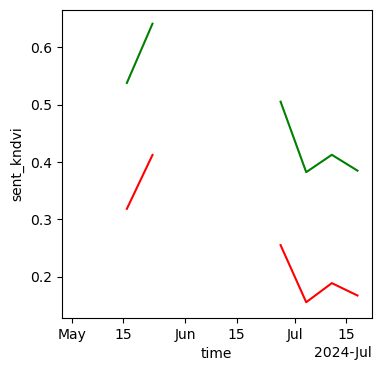

In [335]:
fig, ax = plt.subplots(figsize = (4,4))

# E04BK_ES42_wheat[E04BK_ES42_keys[location]].sent_ndvi.mean(dim =("lat", "lon")).plot( ax= ax, color = "red")

E04BK_DE917_44963126_Wheat.sent_ndvi.mean(dim =["lat", "lon"]).plot( ax= ax, color = 'green')
E04BK_DE917_44963126_Wheat.sent_kndvi.mean(dim =["lat", "lon"]).plot( ax= ax, color = 'red')

/tmp/ipykernel_490856/3002764472.py:21: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


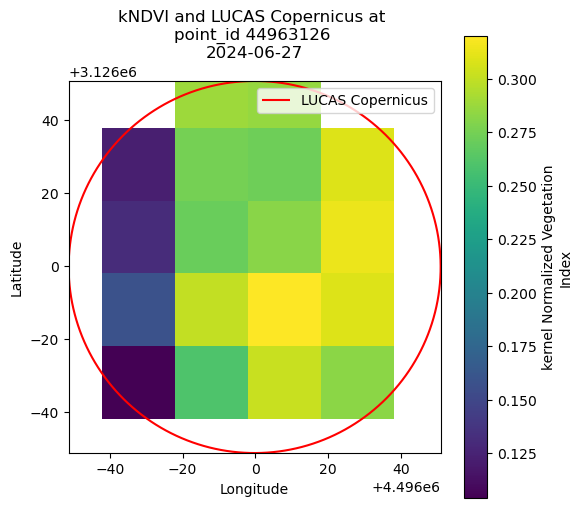

In [336]:
import matplotlib.pyplot as plt

timepoint = 3
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the kNDVI data
E04BK_DE917_44963126_Wheat.sent_kndvi.isel(time=timepoint).plot(ax=ax, label ='kNDVI')

# Select the LUCAS Copernicus matching the Minicube scene
polygon = wheat_hd[wheat_hd['point_id'] == '44963126']

# Plot the polygon 
polygon.boundary.plot(ax=ax, color = 'red', label = 'LUCAS Copernicus')

# get the bounds of the polygon
minx, miny, maxx, maxy = polygon.total_bounds

# Set the limits of the axes to the bounds of the polygon
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.legend()

# 
ax.set_title(f'kNDVI and LUCAS Copernicus at \npoint_id 44963126 \n{np.array(E04BK_DE917_44963126_Wheat.sent_kndvi.isel(time=timepoint).time.data, dtype='datetime64[D]')}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


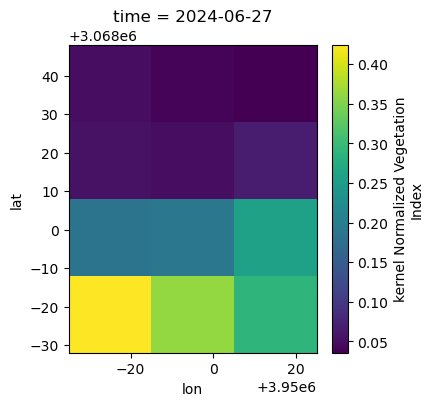

In [205]:
E04BK_BE310_50124194_Flax = xr.open_zarr('/net/projects/EO4BK/WP1/P1-EO4BK/scripts/EO4BK-WP1-P1/output/Flax/hd/BE/Flax_BE310_39503068.zarr')

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (4,4))


E04BK_BE310_50124194_Flax.sent_kndvi.isel(time = 3).plot(ax = ax )


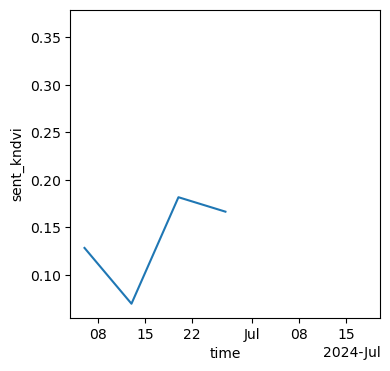

In [206]:
fig, ax = plt.subplots(figsize = (4,4))

# E04BK_ES42_wheat[E04BK_ES42_keys[location]].sent_ndvi.mean(dim =("lat", "lon")).plot( ax= ax, color = "red")

E04BK_BE310_50124194_Flax.sent_kndvi.mean(dim =["lat", "lon"]).plot( ax= ax)

In [9]:
eo4bk = eo4bksentinel(sen_data = sentel_data, lcs_eo4bkdata = wheat_ld, iterative = wheat_ld['point_id'].iloc[:1])

/net/home/dschierbaum/.local/lib/python3.12/site-packages/pandas/core/generic.py:3331: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  return xarray.Dataset.from_dataframe(self)
/net/home/dschierbaum/.local/lib/python3.12/site-packages/pandas/core/generic.py:3331: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 value

In [303]:
keys = eo4bk.keys()
list(keys)[0]

'44923314'

In [288]:
eo4bk[keys]

TypeError: unhashable type: 'dict_keys'

In [8]:
sentel_data = sentle_download(wheat_ld_ov_400sqm, wheat_ld_ov_400sqm['point_id'].iloc[:1])

/net/home/dschierbaum/.conda/envs/wp1v3/lib/python3.12/site-packages/sentle/sentle.py:881: UserWarning: Specified top/bottom bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
/net/home/dschierbaum/.conda/envs/wp1v3/lib/python3.12/site-packages/sentle/sentle.py:888: UserWarning: Specified left/right bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(


In [177]:
eo4bksentinel(sen_data = sentel_data, lcs_eo4bkdata = wheat_ld, iterative = wheat_ld['point_id'].iloc[:1])

/net/home/dschierbaum/.local/lib/python3.12/site-packages/pandas/core/generic.py:3331: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  return xarray.Dataset.from_dataframe(self)
/net/home/dschierbaum/.local/lib/python3.12/site-packages/pandas/core/generic.py:3331: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 value

dask.array<truediv, shape=(12, 5, 4), dtype=float32, chunksize=(1, 5, 4), chunktype=numpy.ndarray>

In [107]:
iterationvalue = wheat_ld['point_id'].iloc[:1]
iterationvalue

0    44923314
Name: point_id, dtype: object

In [115]:
wheat_ld['point_id'].iloc[1:2]

1    37202104
Name: point_id, dtype: object

In [114]:
wheat_ld[wheat_ld['point_id'] == '37202104']

,point_id,survey_date,survey_year,nuts0,nuts1,nuts2,nuts3,poly_area_sqm,lc3,lc_eo4bk,geometry
1,37202104,2022-07-13,2022,ES,ES5,ES51,ES512,342.4,B11,Wheat,"POLYGON ((3719990.882 2103988.663, 3719990.677..."


In [124]:
len(wheat_ld[wheat_ld['poly_area_sqm'] >= 400])

601

In [6]:
wheat_ld_ov_400sqm = wheat_ld[wheat_ld['poly_area_sqm'] >= 400]


sentle_download(wheat_ld_ov_400sqm, wheat_ld_ov_400sqm['point_id'].iloc[:3])

Setting up dask cluster with 7 workers.
Dask client dashboard link: http://127.0.0.1:37382/status


/net/home/dschierbaum/.conda/envs/wp1v3/lib/python3.12/site-packages/sentle/sentle.py:881: UserWarning: Specified top/bottom bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
/net/home/dschierbaum/.conda/envs/wp1v3/lib/python3.12/site-packages/sentle/sentle.py:888: UserWarning: Specified left/right bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
/net/home/dschierbaum/.conda/envs/wp1v3/lib/python3.12/site-packages/sentle/sentle.py:881: UserWarning: Specified top/bottom bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
/net/home/dschierbaum/.conda/envs/wp1v3/lib/python3.12/site-packages/sentle/sentle.py:888: UserWarning: Specified left/right bounds are not perfectly divisable by specified

<xarray.DataArray 'full_like-a064c1c18aa037616b6d1267fdeac964' (time: 11,
                                                                band: 14, y: 2,
                                                                x: 2)> Size: 2kB
dask.array<getitem, shape=(11, 14, 2, 2), dtype=float32, chunksize=(1, 12, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U3 168B 'B01' 'B02' 'B03' 'B04' ... 'B12' 'vv' 'vh'
  * x            (x) float32 8B 3.864e+06 3.864e+06
  * y            (y) float32 8B 3.156e+06 3.156e+06
  * time         (time) datetime64[ns] 88B 2024-07-11 2024-07-04 ... 2024-05-02
    spatial_ref  int64 8B 0

In [116]:
single_wheat_poly = wheat_ld[wheat_ld['point_id'] == '37202104']


In [119]:
plg = single_wheat_poly    # i iteratates through nuts1 regions and j iterates through the single polygon in nuts1 region of i 
# bound_left = int(plg.geometry.bounds[0])
# bound_bottom = int(plg.geometry.bounds[1])
# bound_right = int(plg.geometry.bounds[2])
# bound_top = int(plg.geometry.bounds[3])
bounds_ = plg.geometry.bounds

bound_left = int(bounds_.minx.iloc[0])
bound_bottom = int(bounds_.miny.iloc[0])
bound_right = int(bounds_.maxx.iloc[0])
bound_top = int(bounds_.maxy.iloc[0])

# plg_crs = polygon_list['polygon'][0].crs
plg_crs = plg.crs

da = sentle.process(target_crs=plg_crs,
                    bound_left=bound_left,
                    bound_bottom=bound_bottom,
                    bound_right=bound_right,
                    bound_top=bound_top,
                    datetime="2024-05-01/2024-07-15",
                    target_resolution=20,
                    dask_scheduler_port=10012,
                    dask_dashboard_address='127.0.0.1:37382',
                    S2_mask_snow=True,
                    S2_cloud_classification=True,
                    S2_cloud_classification_device="cpu",
                    S1_assets=["vv", "vh"],
                    S2_apply_snow_mask=True,
                    S2_apply_cloud_mask=True,
                    time_composite_freq="7d",
                    # NOTE clemens: this can be set to 40
                    num_workers=7,
                )

# da = da.rio.write_crs(plg_crs)
# da_cl = da.rio.clip(plg.geometry.apply(mapping), plg_crs)

# da_cl = da.rio.clip([mapping(plg.geometry)], crs=plg_crs)

/net/home/dschierbaum/.conda/envs/wp1v3/lib/python3.12/site-packages/sentle/sentle.py:881: UserWarning: Specified top/bottom bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
/net/home/dschierbaum/.conda/envs/wp1v3/lib/python3.12/site-packages/sentle/sentle.py:888: UserWarning: Specified left/right bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(


In [120]:
da

<xarray.DataArray 'full_like-c5d53f91e50779ae082b87f5841c04c2' (time: 12,
                                                                band: 14, y: 1,
                                                                x: 1)> Size: 672B
dask.array<<this-array>-process_ptile, shape=(12, 14, 1, 1), dtype=float32, chunksize=(1, 12, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) <U3 168B 'B01' 'B02' 'B03' 'B04' ... 'B11' 'B12' 'vv' 'vh'
  * x        (x) float32 4B 3.72e+06
  * y        (y) float32 4B 2.104e+06
  * time     (time) datetime64[ns] 96B 2024-07-18 2024-07-11 ... 2024-05-02

In [44]:
da_cl.sel(band = 'B01').isel(x = 2, y= 2).to_numpy()

array([       nan,  345.622  ,        nan,  601.48425,        nan,
              nan,  492.0435 ,        nan,        nan, 1089.5707 ,
              nan,  987.1435 ], dtype=float32)

In [21]:
import numpy as np


y = [np.nan,  366.7479,np.nan,  591.8993,np.nan, np.nan,543.3037, np.nan, np.nan, 2132.179 ,np.nan, 1808.0728]

x = range(0,len(y))



In [41]:
plt.plot(x,y)

Error in callback <function _draw_all_if_interactive at 0x7d4ed91a71a0> (for post_execute), with arguments args (),kwargs {}:


ValueError: object __array__ method not producing an array

ValueError: object __array__ method not producing an array

<Figure size 640x480 with 1 Axes>

In [40]:
import matplotlib.pyplot as plt

In [27]:
data_np

array([[[[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]]]])

In [39]:
import numpy as np
import matplotlib

print("NumPy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)

NumPy version: 2.1.2
Matplotlib version: 3.9.2
